In [1]:
import numpy as np
import pandas as pd

# 소수를 e로 표현하지 않도록 하기
pd.options.display.float_format = "{:.5f}".format

In [2]:
lib_2007 = pd.read_csv("../final_data/lib_2007.csv", index_col=0)
lib_2008 = pd.read_csv("../final_data/lib_2008.csv", index_col=0)
lib_2009 = pd.read_csv("../final_data/lib_2009.csv", index_col=0)
lib_2010 = pd.read_csv("../final_data/lib_2010.csv", index_col=0)
lib_2011 = pd.read_csv("../final_data/lib_2011.csv", index_col=0)
lib_2012 = pd.read_csv("../final_data/lib_2012.csv", index_col=0)
lib_2013 = pd.read_csv("../final_data/lib_2013.csv", index_col=0)
lib_2014 = pd.read_csv("../final_data/lib_2014.csv", index_col=0)
lib_2015 = pd.read_csv("../final_data/lib_2015.csv", index_col=0)
lib_2016 = pd.read_csv("../final_data/lib_2016.csv", index_col=0)
lib_2017 = pd.read_csv("../final_data/lib_2017.csv", index_col=0)
lib_2018 = pd.read_csv("../final_data/lib_2018.csv", index_col=0)
lib_2019 = pd.read_csv("../final_data/lib_2019.csv", index_col=0)
lib_2020 = pd.read_csv("../final_data/lib_2020.csv", index_col=0)
lib_2021 = pd.read_csv("../final_data/lib_2021.csv", index_col=0)

In [3]:
train_lib = pd.concat([lib_2007,lib_2008,lib_2009,lib_2010,lib_2011,lib_2012,lib_2013,lib_2014,lib_2015, lib_2016, lib_2017])
valid_lib = pd.concat([lib_2018, lib_2019])
test_lib = pd.concat([lib_2020,lib_2021])

In [4]:
# train, test set의 데이터 수 구하기
print(f"train set의 데이터 수 : {len(train_lib)}")
print(f"valid set의 데이터 수 : {len(valid_lib)}")
print(f"test set의 데이터 수 : {len(test_lib)}")

train set의 데이터 수 : 9026
valid set의 데이터 수 : 2222
test set의 데이터 수 : 2370


In [5]:
# 사분위수를 활용하여 비율 충족도의 이상치 행 제거하기
def del_outlier(df, col):
    q1 = df[col].quantile(0.10)
    q3 = df[col].quantile(0.90)
    iqr = q3 - q1 
    boundary = 1.5 * iqr 

    upper_index = df[df[col] > q3 + boundary].index
    lower_index = df[df[col] < q1 - boundary].index 

    df.drop(upper_index, inplace = True)
    df.drop(lower_index, inplace = True)

    return df

del_outlier(train_lib, "future_acq_budget_settlement")
del_outlier(valid_lib, "future_acq_budget_settlement")
del_outlier(test_lib, "future_acq_budget_settlement") 

# 이상치 제거 후 train, test set의 데이터 수 구하기
print(f"이상치 제거 후 train set의 데이터 수 : {len(train_lib)}")
print(f"이상치 제거 후 valid set의 데이터 수 : {len(valid_lib)}")
print(f"이상치 제거 후 test set의 데이터 수 : {len(test_lib)}")

이상치 제거 후 train set의 데이터 수 : 8184
이상치 제거 후 valid set의 데이터 수 : 2178
이상치 제거 후 test set의 데이터 수 : 2310


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 생성
scaler = MinMaxScaler()

# 모든 변수에 대해 Min-Max Scaling 적용
# 스케일러를 학습 데이터에 대해 fit
scaler.fit(train_lib.drop(columns=["future_acq_budget_settlement"]))

# 학습 데이터에 대해 변환
train_lib_scaled = pd.DataFrame(scaler.transform(train_lib.drop(columns=["future_acq_budget_settlement"])), 
                                columns=train_lib.columns[:-1])

# 타겟 변수에 대해 스케일링 적용
scaler_y = MinMaxScaler()
train_y_scaled = scaler_y.fit_transform(train_lib[['future_acq_budget_settlement']])

# 학습 데이터에 스케일된 타겟 변수 추가
train_lib_scaled['future_acq_budget_settlement_scaled'] = train_y_scaled

# 검증 데이터에 대해 변환
valid_lib_scaled = pd.DataFrame(scaler.transform(valid_lib.drop(columns=["future_acq_budget_settlement"])), 
                                columns=train_lib.columns[:-1])
valid_y_scaled = scaler_y.transform(valid_lib[['future_acq_budget_settlement']])
valid_lib_scaled['future_acq_budget_settlement_scaled'] = valid_y_scaled

# 테스트 데이터에 대해 변환
test_lib_scaled = pd.DataFrame(scaler.transform(test_lib.drop(columns=["future_acq_budget_settlement"])), 
                               columns=train_lib.columns[:-1])
test_y_scaled = scaler_y.transform(test_lib[['future_acq_budget_settlement']])
test_lib_scaled['future_acq_budget_settlement_scaled'] = test_y_scaled

# X_train, Y_train 구성하기 (스케일된 타겟 사용)
X_train = train_lib_scaled.drop(columns=["future_acq_budget_settlement_scaled"])
Y_train = train_lib_scaled["future_acq_budget_settlement_scaled"]

# X_valid, Y_valid 구성하기 (스케일된 타겟 사용)
X_valid = valid_lib_scaled.drop(columns=["future_acq_budget_settlement_scaled"])
Y_valid = valid_lib_scaled["future_acq_budget_settlement_scaled"]

# X_test, Y_test 구성하기 (스케일된 타겟 사용)
X_test = test_lib_scaled.drop(columns=["future_acq_budget_settlement_scaled"])
Y_test = test_lib_scaled["future_acq_budget_settlement_scaled"]


In [7]:
X_train.fillna(X_train.mean(), inplace=True)

In [8]:
# 평가지표 출력을 위한 패키지 불러오기
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score 

# 평가지표를 출력하는 함수 만들기
result_df = pd.DataFrame(columns = ["MSE", "RMSE", "MAE", "SMAPE", "R2"])

def print_reg_result(model_name, data_type, valid_y, valid_pred):
    MSE = mean_squared_error(valid_y, valid_pred)
    RMSE = root_mean_squared_error(valid_y, valid_pred)
    MAE = mean_absolute_error(valid_y, valid_pred)
    SMAPE = np.mean((np.abs(valid_y - valid_pred))/(np.abs(valid_y) + np.abs(valid_pred)))*100
    R2 = r2_score(valid_y, valid_pred)
    result_df.loc[len(result_df)] = [model_name, data_type, MSE, RMSE, MAE, SMAPE, R2]

In [9]:
# 트리 기반의 회귀 알고리즘 패키지 불러오기
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# 새로운 하이퍼파라미터로 모델 선언하기
RF_reg = RandomForestRegressor(max_depth = 36, max_features='sqrt', min_samples_leaf=2, min_samples_split=3, n_estimators=322)
ET_reg = ExtraTreesRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=416)
CAT_reg = CatBoostRegressor(border_count=124, depth=4, iterations=136, l2_leaf_reg=8, learning_rate=0.1092250914011541)
LGBM_reg = LGBMRegressor(learning_rate = 0.034478254120072105, max_depth = 16, min_child_samples=4, n_estimators=222, num_leaves=39, subsample=0.8599855723111061)
XGB_reg = XGBRegressor(colsample_bytree=0.6464290562027665, learning_rate=0.023800792606525824, max_depth=3, min_child_weight=4, n_estimators=253, subsample=0.6068644407327001)

In [10]:
model_list = [('Random Forest', RF_reg),
              ('Extra Trees', ET_reg),
              ('Cat Boost', CAT_reg),
              ('Light GBM', LGBM_reg),
              ('XG Boost', XGB_reg)
              ]


result_df = pd.DataFrame(columns=["Model", "Data Type", "MSE", "RMSE", "MAE", "SMAPE", "R2"])

for model_name, model in model_list:
    
    # Fit the model on the entire training data
    model.fit(X_train, Y_train)
    
    # Predict on validation and test data
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    
    # Output the evaluation metrics
    print_reg_result(model_name, 'Train', Y_train, train_pred)
    print_reg_result(model_name, 'Validation', Y_valid, valid_pred)
    print_reg_result(model_name, 'Test', Y_test, test_pred)

0:	learn: 0.1499586	total: 103ms	remaining: 13.9s
1:	learn: 0.1403413	total: 109ms	remaining: 7.31s
2:	learn: 0.1316834	total: 239ms	remaining: 10.6s
3:	learn: 0.1243491	total: 241ms	remaining: 7.95s
4:	learn: 0.1178769	total: 243ms	remaining: 6.37s
5:	learn: 0.1121185	total: 276ms	remaining: 5.97s
6:	learn: 0.1075416	total: 280ms	remaining: 5.16s
7:	learn: 0.1034403	total: 349ms	remaining: 5.59s
8:	learn: 0.0998093	total: 386ms	remaining: 5.44s
9:	learn: 0.0967407	total: 420ms	remaining: 5.3s
10:	learn: 0.0942691	total: 424ms	remaining: 4.81s
11:	learn: 0.0920614	total: 458ms	remaining: 4.73s
12:	learn: 0.0900978	total: 464ms	remaining: 4.39s
13:	learn: 0.0884616	total: 500ms	remaining: 4.36s
14:	learn: 0.0869444	total: 502ms	remaining: 4.05s
15:	learn: 0.0858407	total: 517ms	remaining: 3.87s
16:	learn: 0.0846694	total: 531ms	remaining: 3.72s
17:	learn: 0.0837595	total: 617ms	remaining: 4.04s
18:	learn: 0.0830312	total: 619ms	remaining: 3.81s
19:	learn: 0.0822328	total: 620ms	remainin

In [11]:
print(result_df)

            Model   Data Type     MSE    RMSE     MAE    SMAPE      R2
0   Random Forest       Train 0.00150 0.03879 0.02053  8.44349 0.94229
1   Random Forest  Validation 0.01207 0.10985 0.06293 17.28224 0.56186
2   Random Forest        Test 0.00804 0.08968 0.05452 16.04625 0.69771
3     Extra Trees       Train 0.00066 0.02563 0.01510  7.44313 0.97480
4     Extra Trees  Validation 0.01224 0.11062 0.06670 18.23103 0.55572
5     Extra Trees        Test 0.00883 0.09399 0.06125 18.01146 0.66800
6       Cat Boost       Train 0.00516 0.07184 0.04312 14.54895 0.80201
7       Cat Boost  Validation 0.01249 0.11174 0.06301 17.27693 0.54665
8       Cat Boost        Test 0.00841 0.09170 0.05350 15.72546 0.68394
9       Light GBM       Train 0.00204 0.04518 0.02991 12.04359 0.92169
10      Light GBM  Validation 0.01301 0.11408 0.06515 17.48210 0.52745
11      Light GBM        Test 0.00916 0.09573 0.05620 15.97195 0.65557
12       XG Boost       Train 0.00519 0.07201 0.04288 14.49154 0.80110
13    

In [12]:
# # 새로운 하이퍼파라미터로 모델 선언하기
# RF_reg = RandomForestRegressor(max_depth = 36, max_features='sqrt', min_samples_leaf=2, min_samples_split=3, n_estimators=322)
# ET_reg = ExtraTreesRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=416)
# CAT_reg = CatBoostRegressor(border_count=124, depth=4, iterations=136, l2_leaf_reg=8, learning_rate=0.1092250914011541)
# LGBM_reg = LGBMRegressor(learning_rate = 0.034478254120072105, max_depth = 16, min_child_samples=4, n_estimators=222, num_leaves=39, subsample=0.8599855723111061)
# XGB_reg = XGBRegressor(colsample_bytree=0.6464290562027665, learning_rate=0.023800792606525824, max_depth=3, min_child_weight=4, n_estimators=253, subsample=0.6068644407327001)

In [13]:
# columns_to_drop = ["local_mat", "prog_partic", "service_recip", "self_srv_machines", "interlib_loans", 
#                    "reg_members", "borrowers", "user_ed_partic", "web_access", "open_days", 
#                    "avg_week_hours", "disab_mat", "ann_weeding", "support_staff"]

# X_train.drop(columns=columns_to_drop, inplace=True)
# X_valid.drop(columns=columns_to_drop, inplace=True)
# X_test.drop(columns=columns_to_drop, inplace=True)

In [14]:
# model_list = [('Random Forest', RF_reg),
#               ('Extra Trees', ET_reg),
#               ('Cat Boost', CAT_reg),
#               ('Light GBM', LGBM_reg),
#               ('XG Boost', XGB_reg)
#               ]


# result_df = pd.DataFrame(columns=["Model", "Data Type", "MSE", "RMSE", "MAE", "SMAPE", "R2"])

# for model_name, model in model_list:
    
#     # Fit the model on the entire training data
#     model.fit(X_train, Y_train)
    
#     # Predict on validation and test data
#     train_pred = model.predict(X_train)
#     valid_pred = model.predict(X_valid)
#     test_pred = model.predict(X_test)
    
#     # Output the evaluation metrics
#     print_reg_result(model_name, 'Train', Y_train, train_pred)
#     print_reg_result(model_name, 'Validation', Y_valid, valid_pred)
#     print_reg_result(model_name, 'Test', Y_test, test_pred)

In [15]:
# print(result_df)

### 가장 좋은 성능의 모델에 대해 변수 중요도 구하기

In [33]:
# Random Forest 모델의 변수 중요도 구하기
train_pred = XGB_reg.predict(X_train)
valid_pred = XGB_reg.predict(X_valid)
test_pred = XGB_reg.predict(X_test)

feature_imp_df = pd.DataFrame(XGB_reg.feature_importances_, index = X_train.columns)
feature_imp_df.reset_index(inplace = True)
feature_imp_df.columns = ["Library Factor", "Feature Importance"]

In [34]:
# 변수 중요도가 높은 순서대로 공공도서관 요인 정렬하기
feature_imp_df = feature_imp_df.sort_values("Feature Importance", ascending = False)

In [35]:
# 변수 중요도의 누적합을 담은 열 추가하기
feature_imp_df["Feature Importance"] = feature_imp_df["Feature Importance"]/feature_imp_df["Feature Importance"].sum()
cum_feature_imp = feature_imp_df["Feature Importance"].cumsum()
feature_imp_df.insert(2, "Cumsum of Feature Importance", cum_feature_imp)

In [36]:
# 변수 중요도의 누적합 계산
feature_imp_df["Cumsum of Feature Importance"] = feature_imp_df["Feature Importance"].cumsum()

In [37]:
# 데이터프레임의 인덱스 초기화하기
feature_imp_df.reset_index(inplace = True)
feature_imp_df.drop(columns = "index", inplace= True)

In [38]:
# 변수 중요도에 대한 최종 데이터프레임 출력하기
feature_imp_df

,Library Factor,Feature Importance,Cumsum of Feature Importance
0,acq_budget,0.19827,0.19827
1,acq_budget_settlement,0.16158,0.35985
2,ann_growth,0.08004,0.43988
3,total_budget,0.06073,0.50061
4,lib_build_area,0.05971,0.56033
5,full_time,0.05653,0.61686
6,total_settlement,0.04827,0.66513
7,serials,0.02802,0.69315
8,loans,0.02244,0.71559
9,lib_visitors,0.02122,0.73682


/tmp/ipykernel_225757/2704944506.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_features["Library Factor"], x=top_20_features["Feature Importance"], palette="YlGnBu")


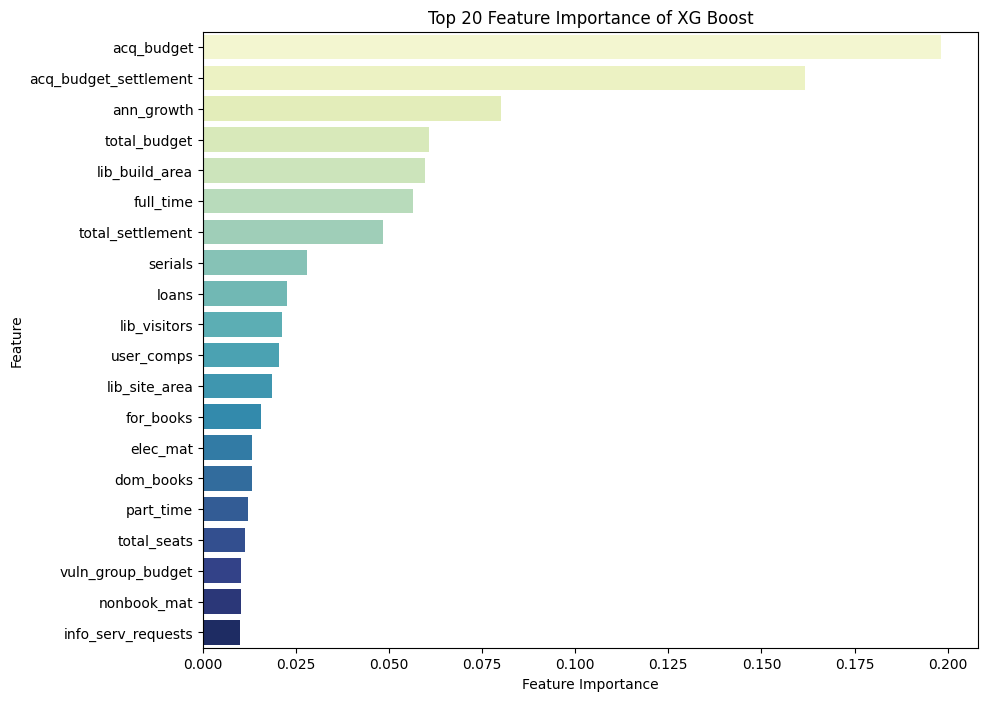

In [39]:
# 각 변수의 상대적 중요도 시각화하기 (Feature Importance Plot)
import seaborn as sns
import matplotlib.pyplot as plt

# 상위 15개 특성만 선택하기
top_20_features = feature_imp_df.nlargest(20, 'Feature Importance')

# 시각화하기
fig = plt.figure(figsize=(10, 8))
sns.barplot(y=top_20_features["Library Factor"], x=top_20_features["Feature Importance"], palette="YlGnBu")
plt.title("Top 20 Feature Importance of XG Boost")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

### Summary Plot 시각화

/root/anaconda3/envs/jw_tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


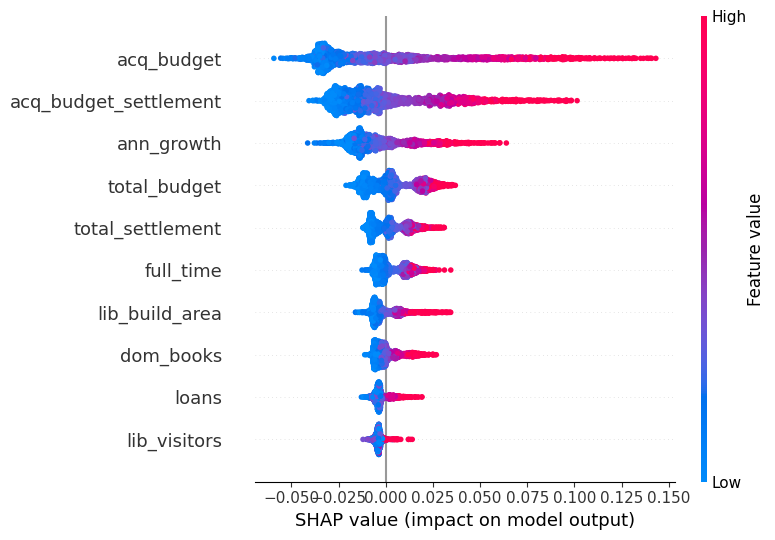

In [23]:
import shap

explainer = shap.TreeExplainer(RF_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

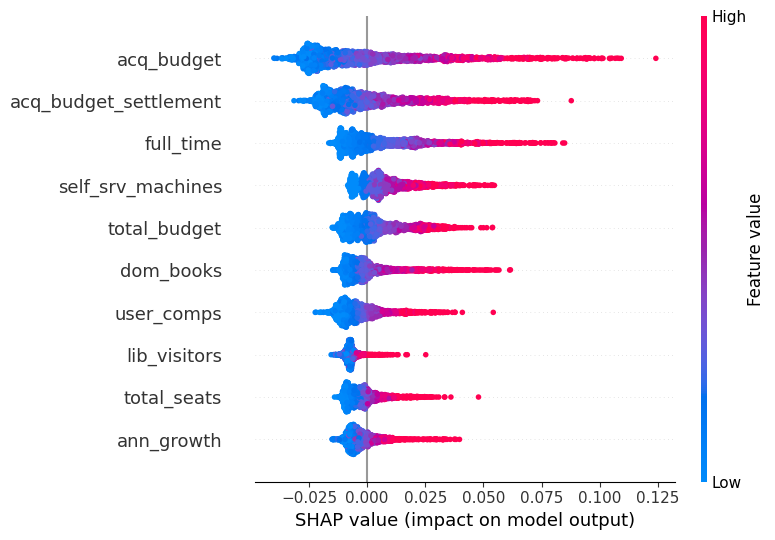

In [24]:
explainer = shap.TreeExplainer(ET_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

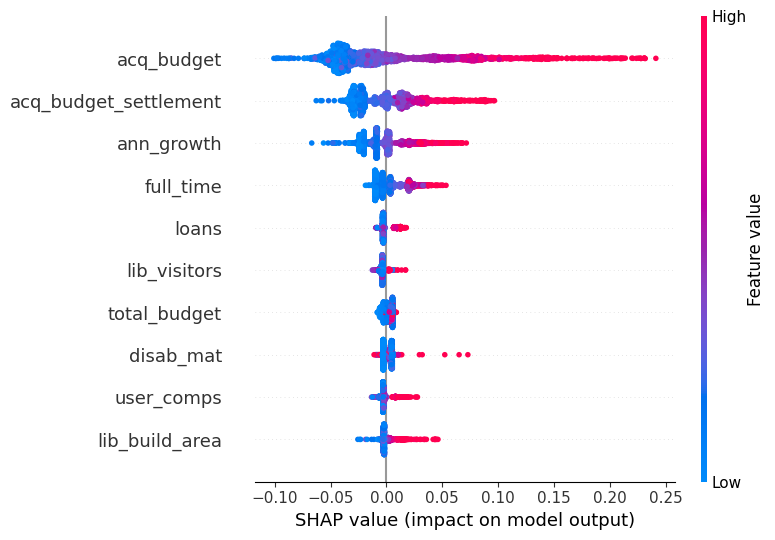

In [25]:
explainer = shap.TreeExplainer(CAT_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

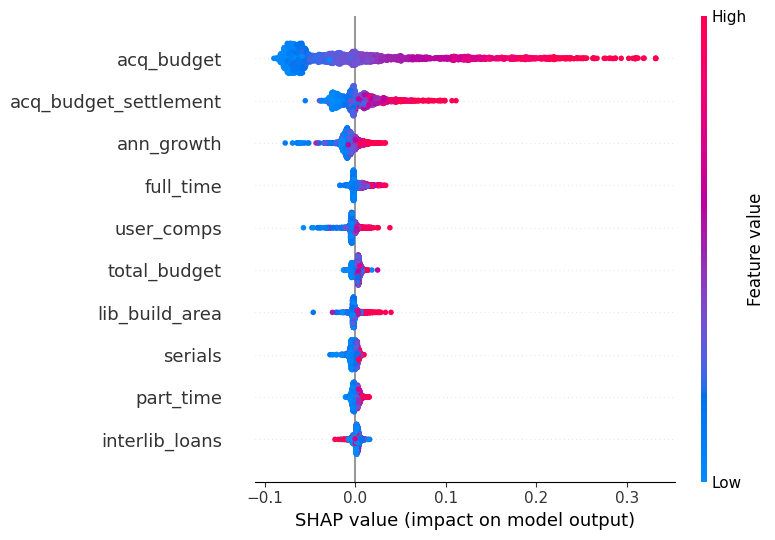

In [26]:
explainer = shap.TreeExplainer(LGBM_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

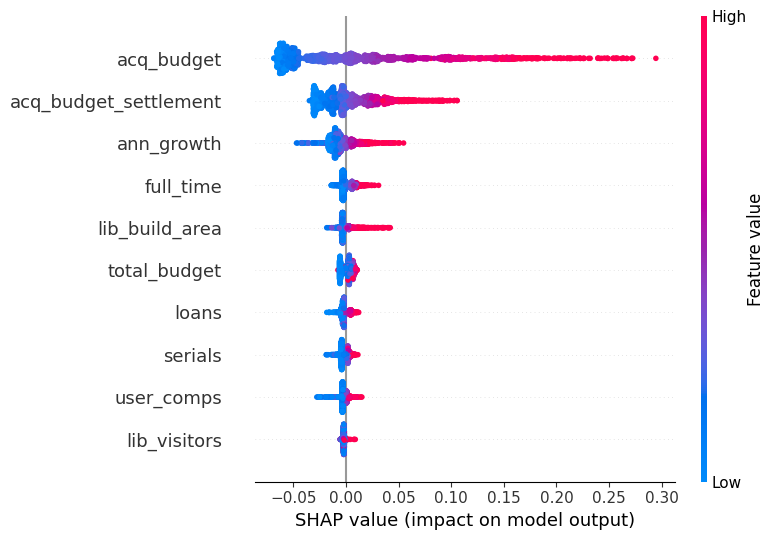

In [27]:
explainer = shap.TreeExplainer(XGB_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

### Force Plot 시각화

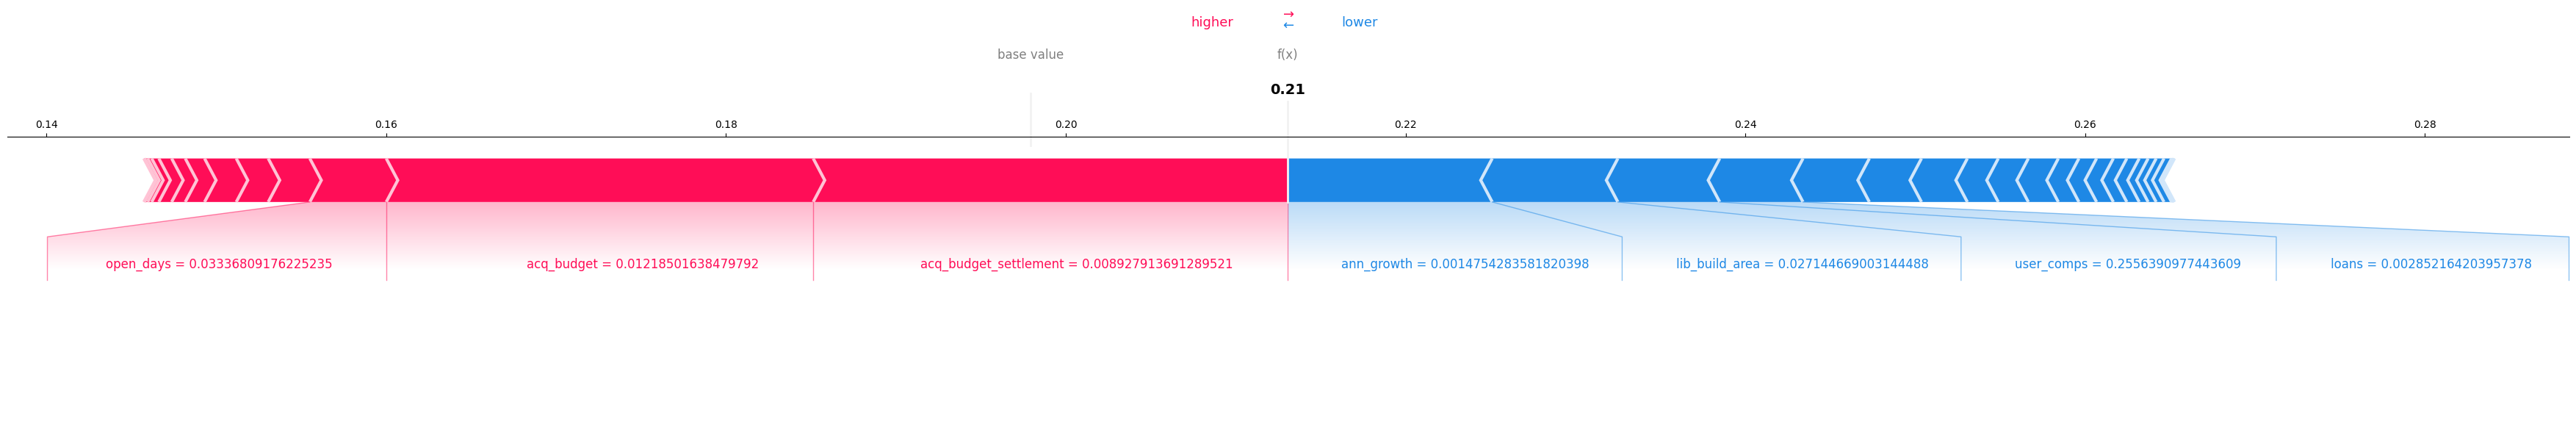

In [38]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(RF_reg)
shap_values = explainer(X_test)

shap.force_plot(explainer.expected_value, shap_values.values[6], X_test.iloc[0], matplotlib=True, figsize=(45, 5))
plt.show()

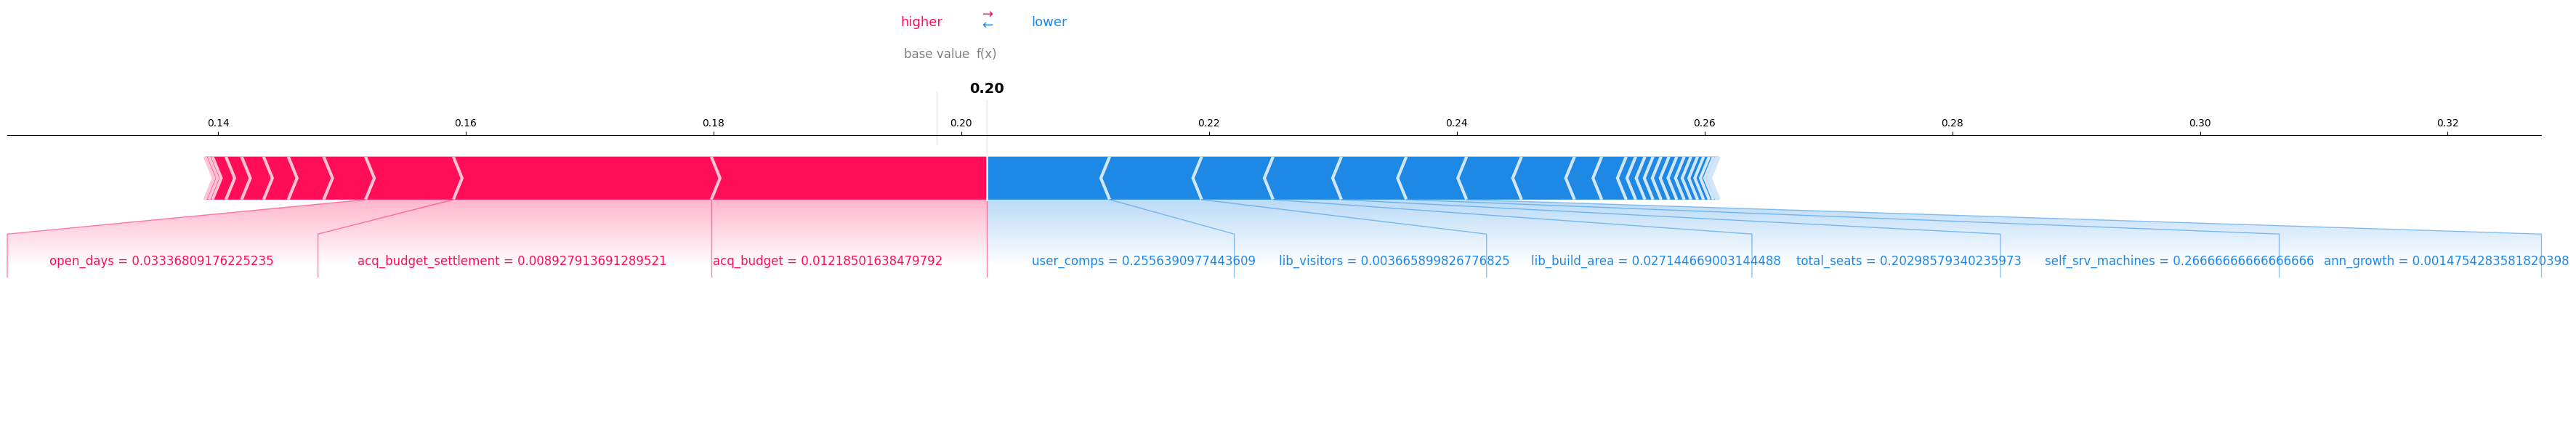

In [39]:
explainer = shap.TreeExplainer(ET_reg)
shap_values = explainer(X_test)
shap.force_plot(explainer.expected_value, shap_values.values[6], X_test.iloc[0], matplotlib=True, figsize=(45, 5))
plt.show()

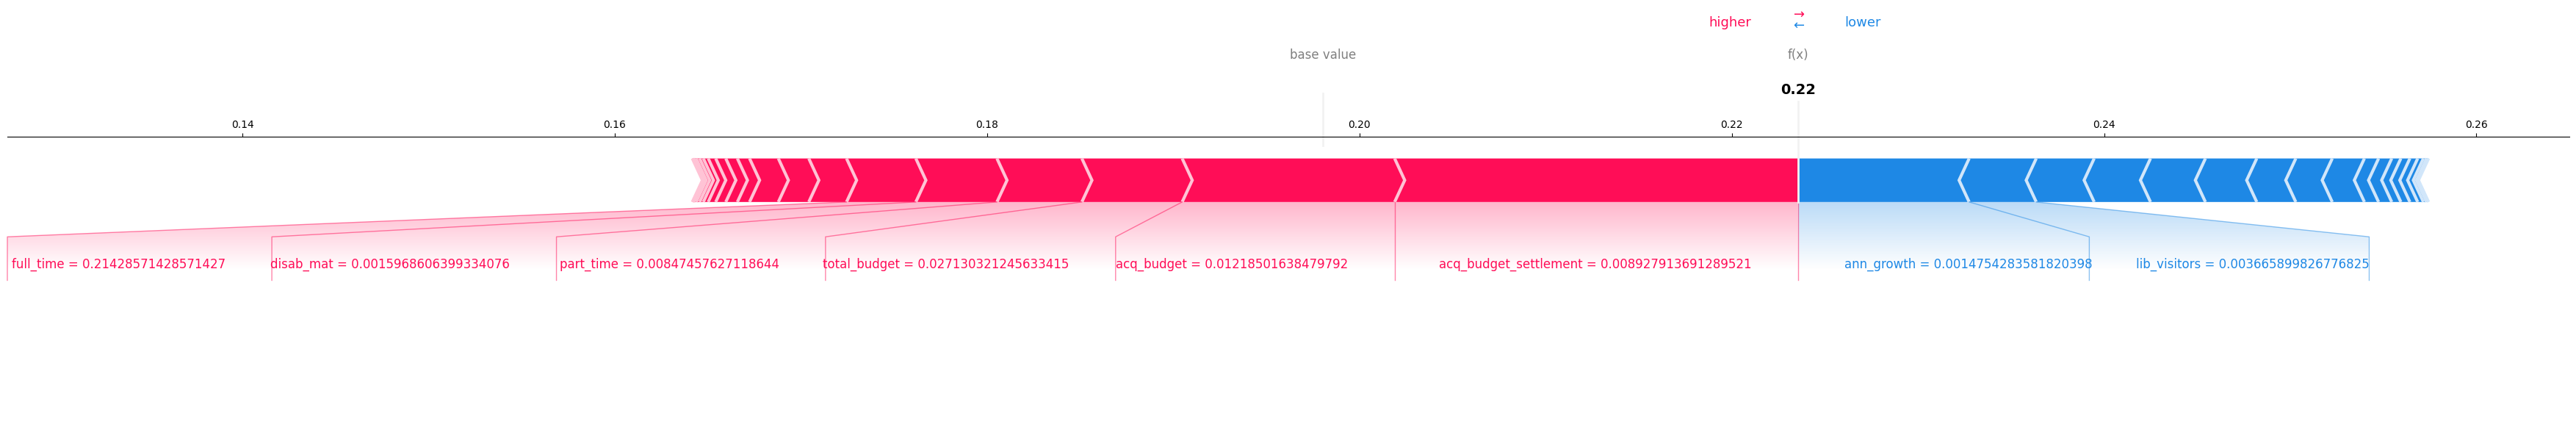

In [37]:
shap.force_plot(explainer.expected_value, shap_values.values[6], X_test.iloc[0], matplotlib=True, figsize=(45, 5))
plt.show()

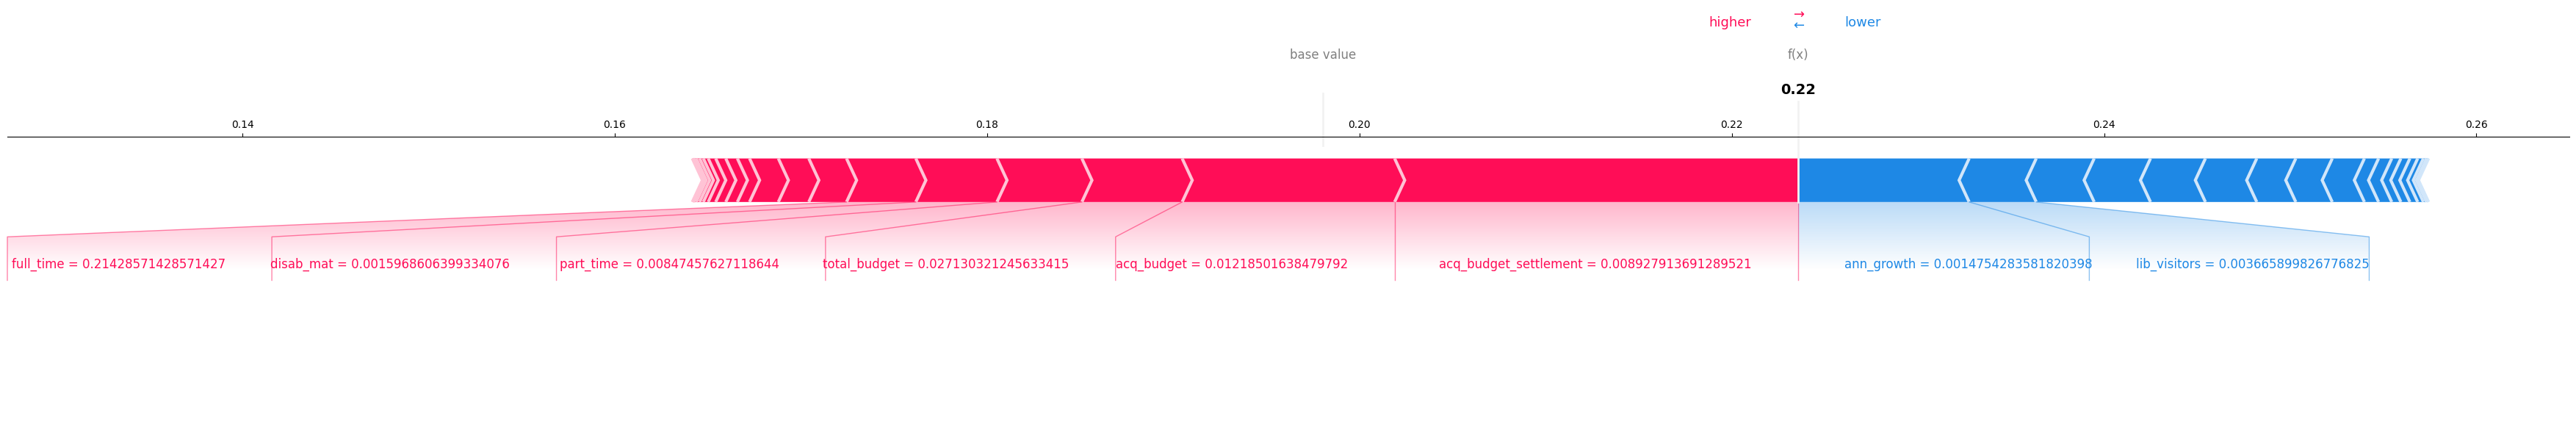

In [36]:
explainer = shap.TreeExplainer(CAT_reg)
shap_values = explainer(X_test)
shap.force_plot(explainer.expected_value, shap_values.values[6], X_test.iloc[0], matplotlib=True, figsize=(45, 5))
plt.show()

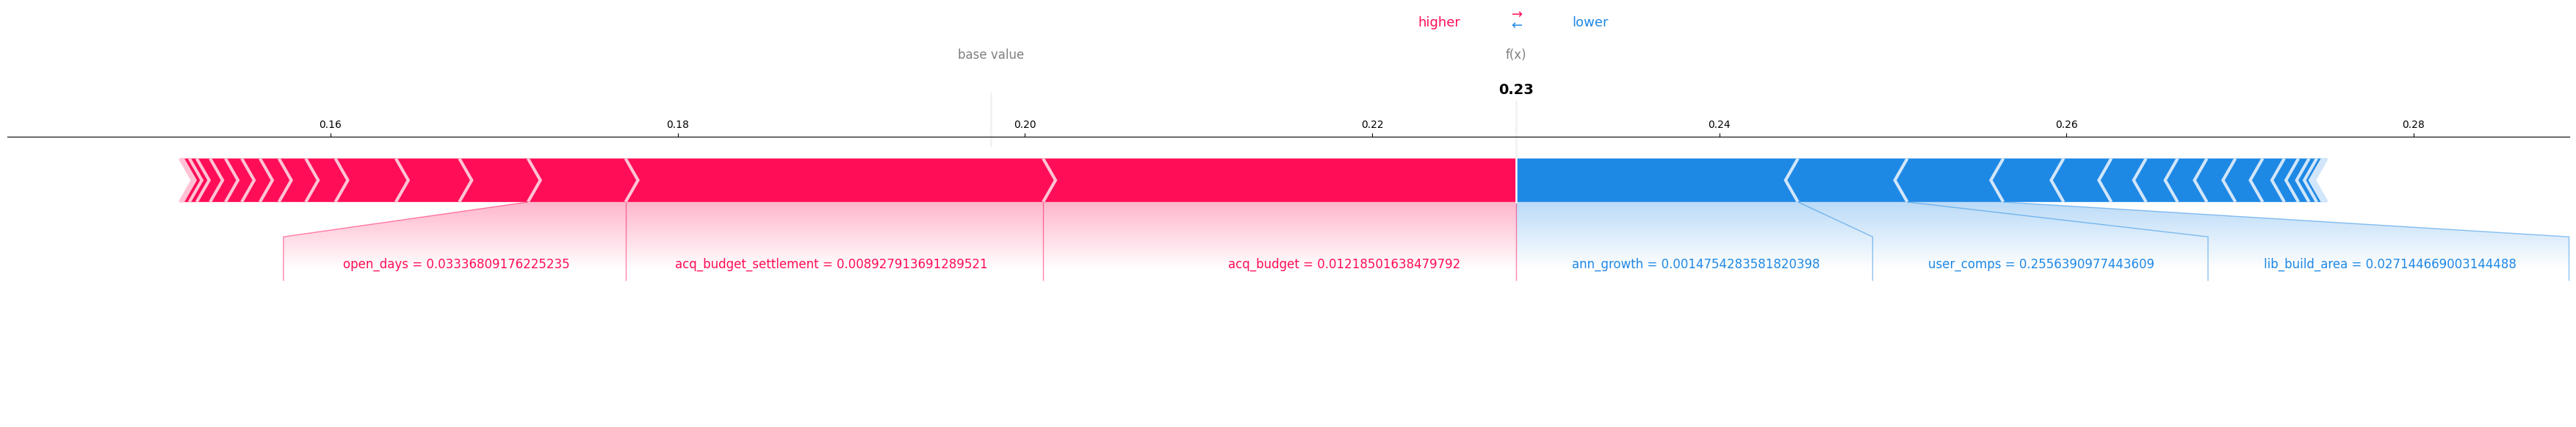

In [35]:
explainer = shap.TreeExplainer(LGBM_reg)
shap_values = explainer(X_test)
shap.force_plot(explainer.expected_value, shap_values.values[6], X_test.iloc[0], matplotlib=True, figsize=(45, 5))
plt.show()

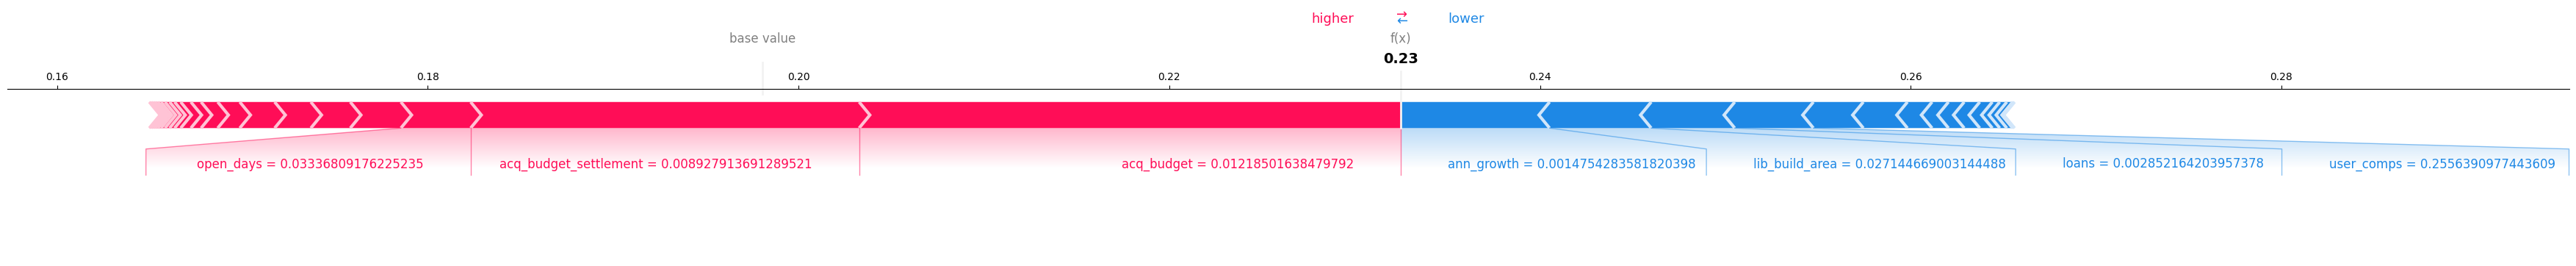

In [34]:
explainer = shap.TreeExplainer(XGB_reg)
shap_values = explainer(X_test)
shap.force_plot(explainer.expected_value, shap_values.values[6], X_test.iloc[0], matplotlib=True, figsize=(45, 3))
plt.show()